In [1]:
import matplotlib.pyplot as plt

from dataset import Dataset, ActivityType, SAMPLE_RATE, Sensor
import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

# Prepare dataset directory

Dataset is from `PhysioNet` can be retrived from this URL:

https://physionet.org/content/accelerometry-walk-climb-drive/1.0.0/

You can download and extract it under `dataset` directory or alternatively run the following cell:

In [10]:
!wget -c --timeout 10 https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -O dataset.zip
!unzip -d dataset -q dataset.zip
!echo "Done!"

--2023-02-19 15:23:33--  https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Done!


# Read dataset

Using `Dataset` class from `dataset.py` module, we can easily interact with accelerometer data.
It reads all individual CSV files from different subjects and gives a nice API to query data.

First, we need to create an object from `Dataset` class:

In [8]:
dset = Dataset("./dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data")

Then using `get` function, different types of data can be read from dataset. For example data related to
Walking activity from left wrist sensor. The function returns numpy array with shape (n x 3) where n is number
of samples drawn from data-set and 3 corresponds to number of axes we have which are X, Y and Z.

Here are three samples:

In [125]:
w = dset.get(ActivityType.WALKING, Sensor.LEFT_WRIST)
d = dset.get(ActivityType.ASCENDING, Sensor.LEFT_WRIST)
a = dset.get(ActivityType.DESCENDING, Sensor.LEFT_WRIST)

print(w.shape)
print(d.shape)
print(a.shape)

(336167, 3)
(59253, 3)
(56113, 3)


# Miscelounce functions

In [140]:
def get_magnitude(data, normalize=True):
    """
    Calculate vector magnitude from XYZ axes.
    inputs:
        data: A numpy array with shape (n x 3), n is number of samples and
        there are 3 axes X, Y, Z respectively.
        
        normalize: If true, perform normalization on resulting vector magnitude
        
    output:
        vector magnitude with shape: (n x 1), n is number if samples
    """
    data = np.sum(data ** 2, axis=1)
    if normalize:
        data = (data - data.mean()) / data.std()
    return data


def get_fft(x):
    """
    Compute FFT from input array x
    
    input:
        x: Input array of shape (n x 1)
        
    output:
        A Tuple containing two arrays. First item is frequency and the second item is power
    """
    p = fft(x)
    f = fftfreq(x.shape[0], SAMPLE_RATE)
    p = np.abs(p)

    msk = np.logical_and(f >= 0, f < 20)
    f = f[msk]
    p = p[msk]
    
    #damp = 1/(1 + np.exp(-(f-10)))
    #damp = 1 - damp
    #p *= damp
    
    return f, p


def low_pass(x, cutoff):
    """
    Pass input signal x through a lowpass filter with a certain cutoff frequency.
    All frequency components higher than cutoff frequency will be damped to zero.
    """
    p = fft(x)
    f = fftfreq(x.shape[0], SAMPLE_RATE)
    p[f >= cutoff] = 0
    p[f < 0] = 0
    y = ifft(p)
    y = np.real(y)
    y = y / y.std()
    return y
    
def plot_svm(clf, X, y):
    """
    Given a svm classifier, input data X and its label, it plot data and the lassifier decision boundries
    """
    decision_function = clf.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()

    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )

    #plt.scatter(
    #    support_vectors[:, 0],
    #    support_vectors[:, 1],
    #    s=100,
    #    linewidth=1,
    #    facecolors="none",
    #    edgecolors="k",
    #)

# Data visualization

## XYZ axes
Now, let's briefly look at the data. Here, three individual axes from a sample walking activity are plotted.

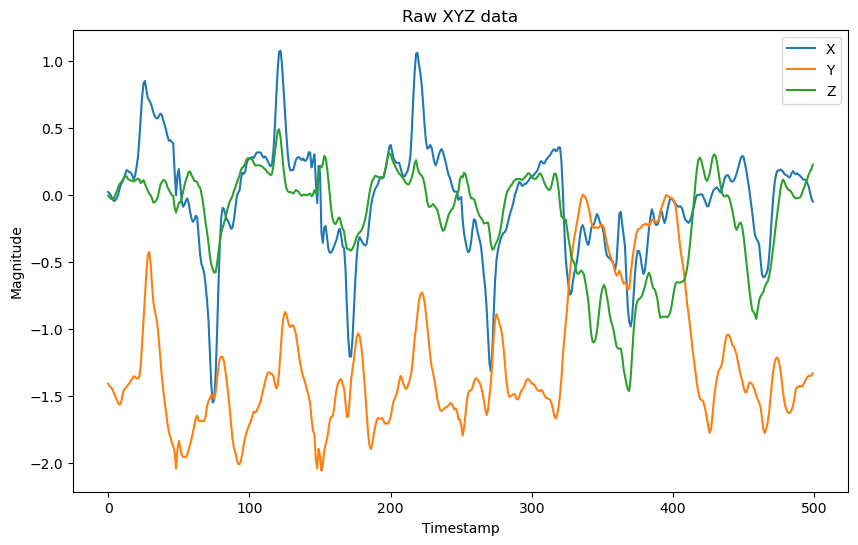

In [134]:
x = dset.get(ActivityType.WALKING, Sensor.LEFT_WRIST, start=1, duration=5)

fig = plt.figure(figsize=(10,6))

plt.plot(x, label=["X", "Y", "Z"])
plt.title("Raw XYZ data")
plt.xlabel("Timestamp")
plt.ylabel("Magnitude")
plt.legend()

## Vector magnitude
To transform three axes to one dimension that represnts original information, vector magnitude
can be computed out of xyz data. Then, by passing it through a lowpass filter, noise and unwanted
signal can be removed from signal.

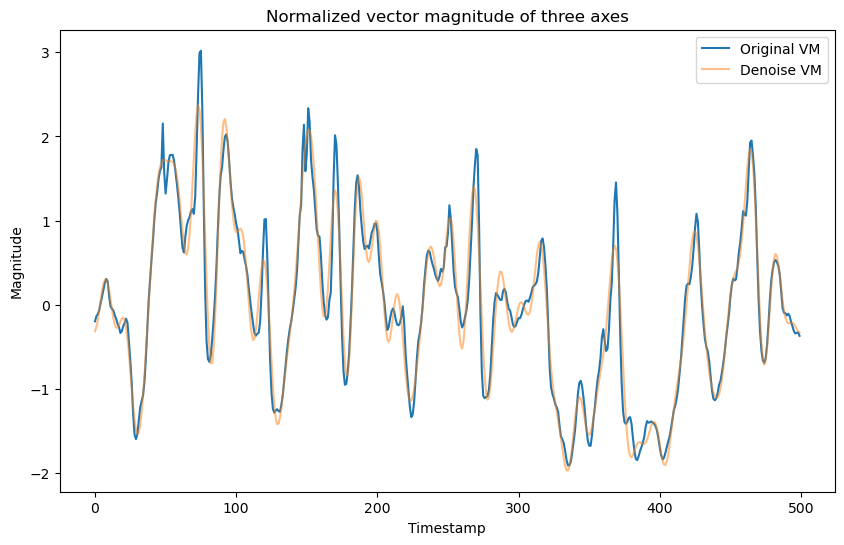

In [135]:
fig = plt.figure(figsize=(10,6))

vm = get_magnitude(x)
vm_denoise = low_pass(vm, 8)

plt.plot(vm, label="Original VM")
plt.plot(vm_denoise, label="Denoise VM", alpha=0.5)
plt.title("Normalized vector magnitude of three axes")
plt.xlabel("Timestamp")
plt.ylabel("Magnitude")
plt.legend()

## Compare VM and FFT of different activities

To have a long shot overview of data, three vector magnitude ofdifferent activities walking, ascending
and descending stairways are plotted side by side.

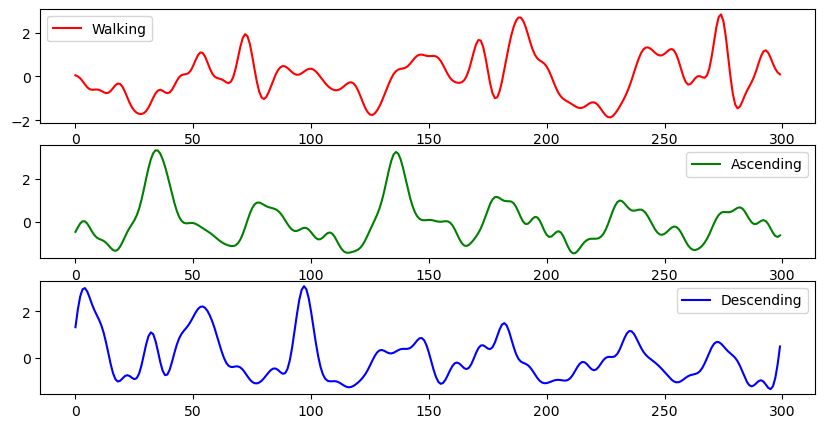

In [136]:
w = dset.get(ActivityType.WALKING, Sensor.LEFT_WRIST, start=20, duration=3)
a = dset.get(ActivityType.ASCENDING, Sensor.LEFT_WRIST, start=20, duration=3)
d = dset.get(ActivityType.DESCENDING, Sensor.LEFT_WRIST, start=20, duration=3)

w = low_pass(get_magnitude(w), 12)
a = low_pass(get_magnitude(a), 12)
d = low_pass(get_magnitude(d), 12)


fig = plt.figure(figsize=(10,5))
fig.tight_layout()

ax = plt.subplot(311)
ax.plot(w, label="Walking", color='red')
ax.legend()

ax = plt.subplot(312)
ax.plot(a, label="Ascending", color='green')
ax.legend()

ax = plt.subplot(313)
ax.plot(d, label="Descending", color='blue')
ax.legend()

plt.legend()

Now, let's take a look at those signals in frequency domain:

Text(0, 0.5, 'Power')

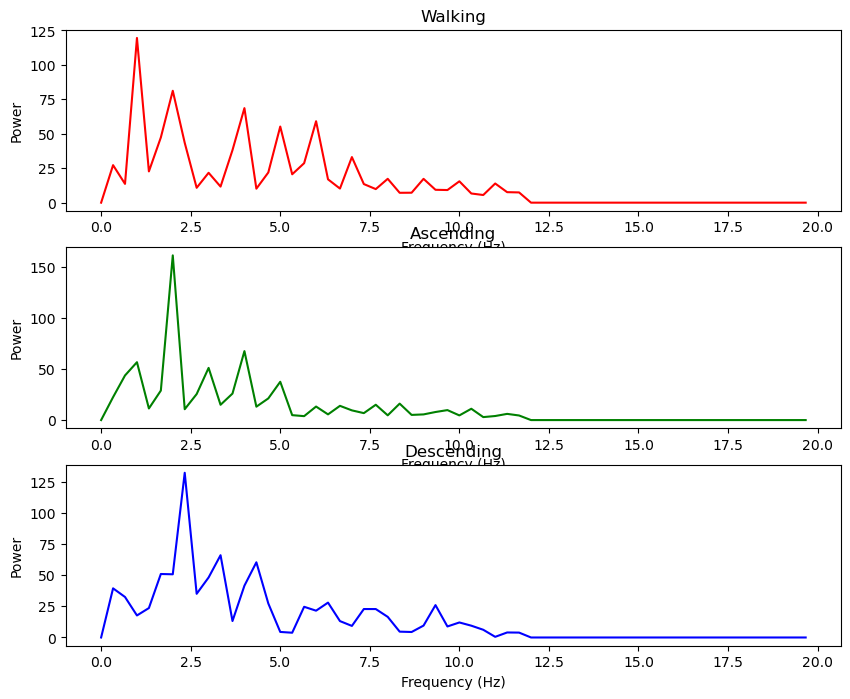

In [137]:
f1, p1 = get_fft(w)
f2, p2 = get_fft(a)
f3, p3 = get_fft(d)

fig = plt.figure(figsize=(10,8))
fig.tight_layout()

ax = plt.subplot(311)
ax.plot(f1, p1, color='red')
ax.set_title("Walking")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")

ax = plt.subplot(312)
ax.plot(f2, p2, color='green')
ax.set_title("Ascending")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")


ax = plt.subplot(313)
ax.plot(f3, p3, color='blue')
ax.set_title("Descending")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")


# PCA on RAW data

The final aim of procrssing this data is to recognize different human activities. To achieve this we performed
different processing methods to see how they can classify different signals. Here, we tried to classify walking
and descending activities.

The first approach we came up with, is to perform PCA directly on vector magnitude.

In [138]:
raw_feats = []
for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 20)
    raw_feats.append([ActivityType.WALKING.value, *x])
    
    x = dset.get(ActivityType.DESCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 20)
    raw_feats.append([ActivityType.DESCENDING.value, *x])
    
    #x = dset.get(ActivityType.ASCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    #x = low_pass(get_magnitude(x), 20)
    #raw_feats.append([ActivityType.ASCENDING.value, *x])

raw_feats = np.array(raw_feats)
print(raw_feats.shape)

(200, 501)


[0.1135177  0.08879722]
(200, 2)


<AxesSubplot: >

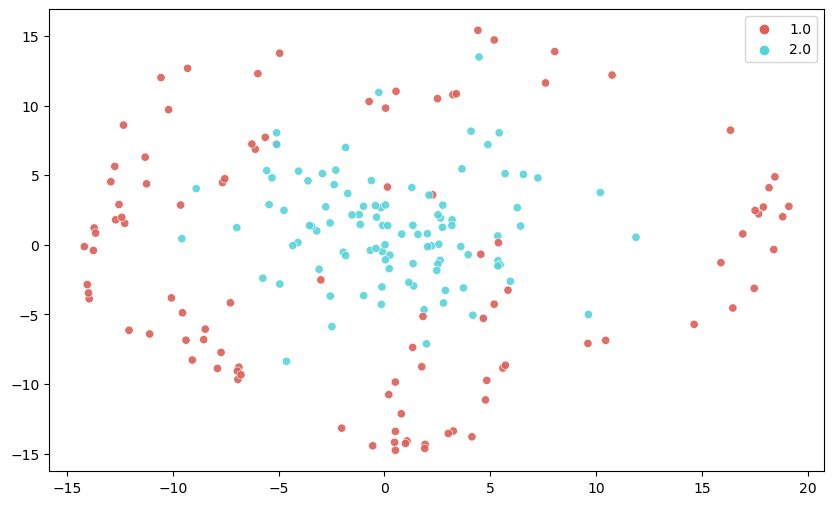

In [139]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(raw_feats)
print(pca.explained_variance_ratio_)
print(pca_result.shape)
plt.figure(figsize=(10,6))

x = pca_result[:,0]
y = pca_result[:,1]

sns.scatterplot(
    x=x, y=y,
    hue=raw_feats[:,0],
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.9,
)

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.scatter(
#    xs=x, 
#    ys=y, 
#    zs=z, 
#    c=raw_feats[:,0], 
#    cmap='tab10'
#)

On the figure above, although two classes are rather nicely seperated, they are not linearly seperable.

## SVM


By utilizing SVM and radial basis function kernel, we can do classify these two activities.
Here you can see decision boundries suggested by SVM visualized by solid line. Also, dashed line
is showing svm margin, means that how much this classifier can tolerant missclassied samples.

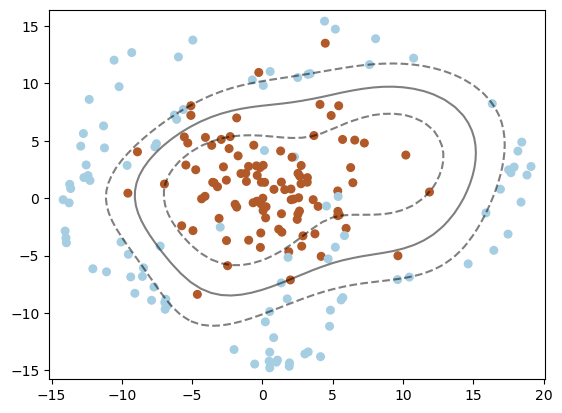

In [141]:
X = pca_result
y = raw_feats[:,0]

clf = svm.SVC(kernel='rbf', C=10)
clf.fit(X, y)

plot_svm(clf, X, y)

# PCA on heuristic features

Now, let's push our idea a bit forward and try to extract some features out of vector magnitude.
Here, we calculated 9 different features, both in frequency and time domain.

Features description:

* `f1`: Dominant frequency providing an estimate of cadence
* `p1`: Partial area under spectrum at `f1`
* `ratio_vm`: Ratio of the partial area under the spectrum related to periodic movement to the complement
* `p1_tp`: Ratio of p1 to the total area under the power spectrum between 0.3-12.5 Hz
* Mean value of power spectrum
* Standard deviation of power spectrum
* Area under spectrum of vector magnitude in time domain
* Summation of positive values of vector magnitude
* Summation of negative values of vector magnitude

In [142]:
def extract_features(x):
    f, p = get_fft(x)
    f1 = f[np.argmax(p)]

    p1 = np.max(p)
    
    ratio_vm = p1 / np.sum(p)
    
    msk = np.logical_and(f > 0.3, f < 12.5)
    p1_tp = p1 / np.sum(p[msk])
    
    return f1, p1, ratio_vm, p1_tp, p.mean(), p.std(), np.sum(x), np.sum(x[x>0]), np.sum(x[x<0])
    
    

feats = []
for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    feats.append([ActivityType.WALKING.value, *extract_features(x)])
    
    x = dset.get(ActivityType.DESCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    feats.append([ActivityType.DESCENDING.value, *extract_features(x)])

    
feats = np.array(feats)
print(feats.shape)

(200, 10)


Percent of dataset explained by PCA: 99.67245967477176


<AxesSubplot: >

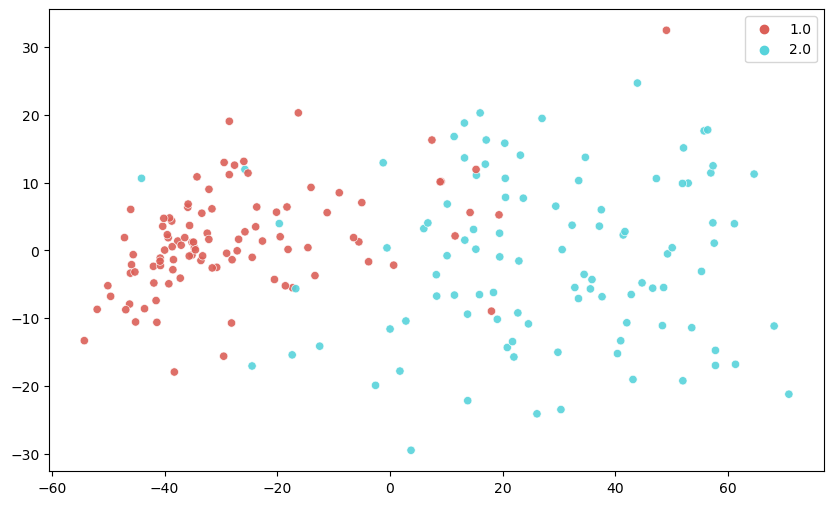

In [147]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feats[:,1:])

explain = np.sum(pca.explained_variance_ratio_)
print(f"Percent of dataset explained by PCA: {explain * 100}")

plt.figure(figsize=(10,6))

x = pca_result[:,0]
y = pca_result[:,1]

sns.scatterplot(
    x=x, y=y,
    hue=feats[:,0],
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.9
)

## SVM

Now, let's perform SVM on this dataset:

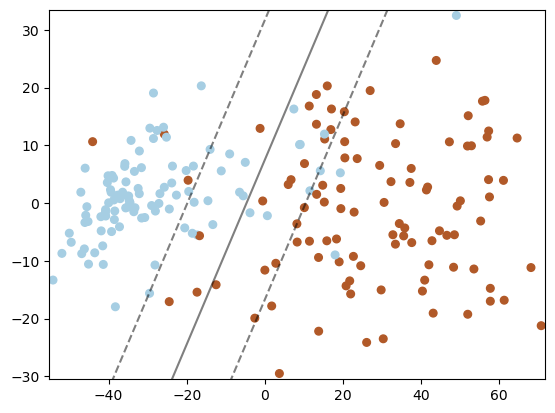

In [144]:
X = pca_result
y = feats[:,0]

clf = svm.SVC(kernel='linear')
clf.fit(X, y)

plot_svm(clf, X, y)

## t-SNE

In addition to PCA, we also can use t-SNE method to reduce dimensionality of signal.
Based on observing components from t-SNE, we can visualize data and see how good they are
seperable from each other. The more two classes far from each other, the better classification
accuracy we can get.


/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 9.676026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.934242
[t-SNE] KL divergence after 300 iterations: 0.163427


/tmp/ipykernel_228640/477799551.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: >

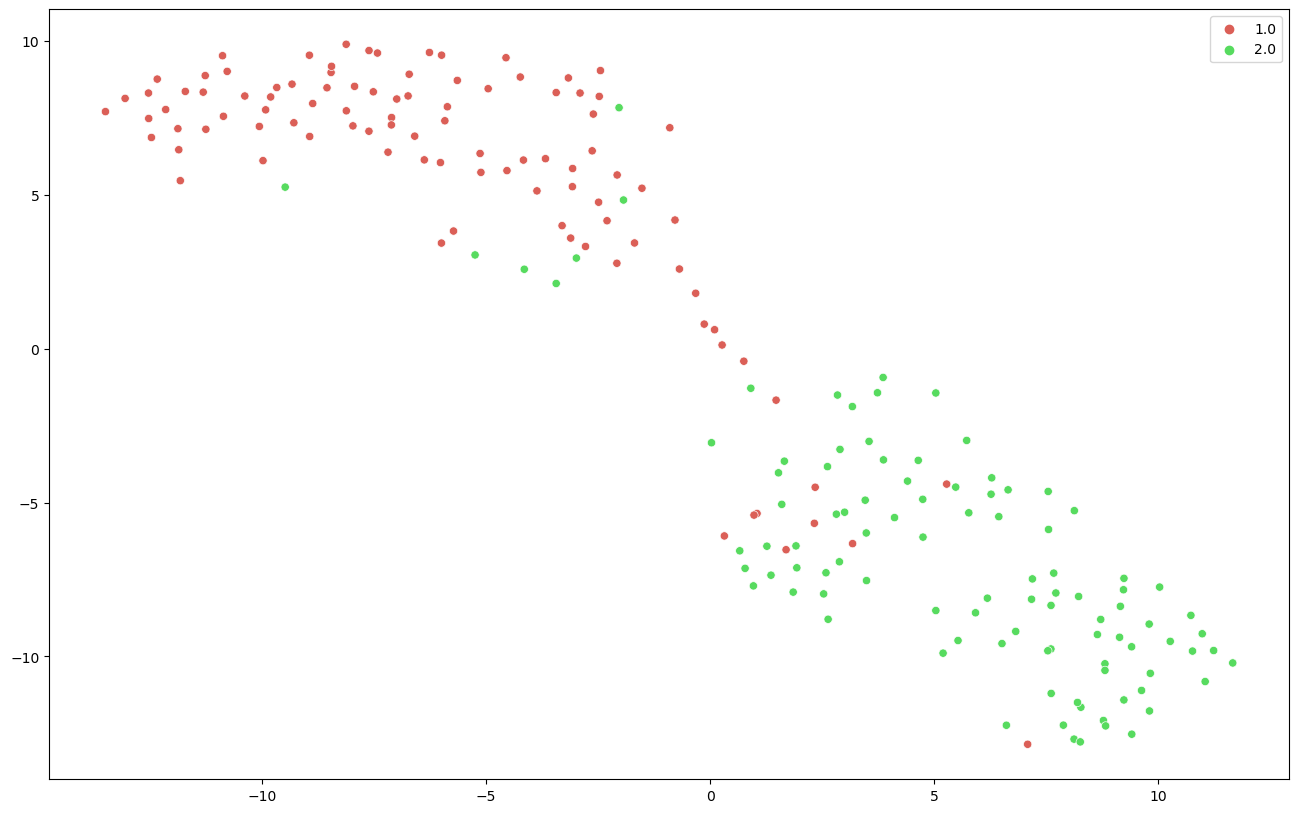

In [149]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats[:,1:])


x = tsne_results[:,0]
y = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=x, y=y,
    hue=feats[:,0],
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=1
)


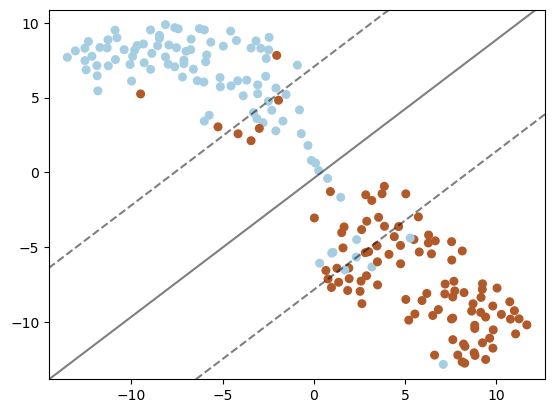

In [150]:
X = tsne_results
y = feats[:,0]

clf = svm.SVC(kernel='linear', C=1)
clf.fit(X, y)

plot_svm(clf, X, y)